### I. Imports et chargement des données

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import gaussian_kde  

In [2]:
CSV_URL = "https://huggingface.co/datasets/flodussart/getaround_pricing_project/resolve/main/get_around_pricing_project.csv"

df_pricing = pd.read_csv(CSV_URL)
df_pricing.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [3]:
df_pricing.columns

Index(['Unnamed: 0', 'model_key', 'mileage', 'engine_power', 'fuel',
       'paint_color', 'car_type', 'private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires', 'rental_price_per_day'],
      dtype='object')

In [4]:
# Work on a copy to avoid mutating the original dataframe
df = df_pricing.copy()

# Drop csv export artifact column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       4843 non-null   int64 
dtypes: bool(

In [ ]:
# Inspect boolean feature columns and confirm they can be safely cast to integers
BOOL = [
    "private_parking_available",
    "has_gps",
    "has_air_conditioning",
    "automatic_car",
    "has_getaround_connect",
    "has_speed_regulator",
    "winter_tires",
]

In [8]:
for col in BOOL:
    print(col, df[col].unique())

private_parking_available [ True False]
has_gps [ True False]
has_air_conditioning [False  True]
automatic_car [False  True]
has_getaround_connect [ True False]
has_speed_regulator [ True False]
winter_tires [ True False]


In [9]:
df_bool = pd.DataFrame({"bool_col": [True, False, True]})
print(df_bool)
print(df_bool.bool_col.astype(int))

   bool_col
0      True
1     False
2      True
0    1
1    0
2    1
Name: bool_col, dtype: int64


### EDA

#### 1. Statistiques descriptives

In [10]:
# Basic stats

print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include="all")
print(data_desc)

print("Percentage of missing values: ")
display(100 * df.isnull().sum() / df.shape[0])

Number of rows : 4843

Display of dataset: 


,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183



Basics statistics: 
       model_key       mileage  engine_power    fuel paint_color car_type  \
count       4843  4.843000e+03    4843.00000    4843        4843     4843   
unique        28           NaN           NaN       4          10        8   
top      Citroën           NaN           NaN  diesel       black   estate   
freq         969           NaN           NaN    4641        1633     1606   
mean         NaN  1.409628e+05     128.98823     NaN         NaN      NaN   
std          NaN  6.019674e+04      38.99336     NaN         NaN      NaN   
min          NaN -6.400000e+01       0.00000     NaN         NaN      NaN   
25%          NaN  1.029135e+05     100.00000     NaN         NaN      NaN   
50%          NaN  1.410800e+05     120.00000     NaN         NaN      NaN   
75%          NaN  1.751955e+05     135.00000     NaN         NaN      NaN   
max          NaN  1.000376e+06     423.00000     NaN         NaN      NaN   

       private_parking_available has_gps has_air_condi

model_key                    0.0
mileage                      0.0
engine_power                 0.0
fuel                         0.0
paint_color                  0.0
car_type                     0.0
private_parking_available    0.0
has_gps                      0.0
has_air_conditioning         0.0
automatic_car                0.0
has_getaround_connect        0.0
has_speed_regulator          0.0
winter_tires                 0.0
rental_price_per_day         0.0
dtype: float64

<div style="font-size:0.85em; line-height:1.4">
Synthèse rapide — rental_price_per_day

- Volume : 4 843 observations — aucune valeur manquante
- Niveau de prix :
    - Médiane : 119 € / jour
    - Moyenne : 121,2 € / jour
- Dispersion :
    - IQR (Q3−Q1) = 136 − 104 = 32 €
    - Écart-type : 33,6 €
    - → La moitié des voitures se situe entre 104 € et 136 €
- Extrêmes et distribution : 
    - min : 10 €, max : 422 € 
    - → Distribution asymétrique à droite, avec quelques modèles très chers

</div>

#### 2. Distribution des prix de location

> Afin de mieux visualiser la forme de la distribution des prix, une courbe de densité
(KDE) est superposée à l’histogramme. La densité est mise à l’échelle pour être
comparable aux effectifs de l’histogramme.

In [11]:
x = df["rental_price_per_day"]

# Histogram
fig = px.histogram(
    x=x,
    nbins=30,
    title="Distribution du prix de location",
    labels={"x": "Prix par jour (€)", "y": "Nombre de voitures"},
    opacity=0.85,
)

# KDE curve scaled to histogram counts
grid = np.linspace(x.min(), x.max(), 200)  
kde = gaussian_kde(x)  
bin_edges = np.histogram_bin_edges(x, bins=30)  
bin_width = bin_edges[1] - bin_edges[0]
y_density = kde(grid) * len(x) * bin_width  

fig.add_scatter(
    x=grid,
    y=y_density, 
    mode="lines", 
    name="KDE", 
    line=dict(width=2))

fig.update_layout(bargap=0.05, template="simple_white", title_x=0.5)

fig.show()

In [12]:
# Correlation of numeric features with rental price
corr_with_price = df.corr(numeric_only=True)["rental_price_per_day"].sort_values(
    ascending=False
)

corr_with_price

rental_price_per_day         1.000000
engine_power                 0.625645
automatic_car                0.419761
has_getaround_connect        0.318486
has_gps                      0.310889
private_parking_available    0.281358
has_air_conditioning         0.245386
has_speed_regulator          0.227547
winter_tires                 0.018277
mileage                     -0.448912
Name: rental_price_per_day, dtype: float64

<div style="font-size:0.85em; line-height:1.35em">
Lecture des corrélations avec rental_price_per_day

- `engine_power` (+0.63) : corrélation forte et positive — les véhicules plus puissants sont en moyenne loués plus cher.
- `automatic_car` (+0.42) : corrélation modérée et positive — la boîte auto est associée à un prix/jour plus élevé.
- Équipements (`has_getaround_connect`, `has_gps`, `private_parking_available`, `has_air_conditioning`, `has_speed_regulator` ) (+0.23 à +0.32) : corrélations positives — plus d’options → positionnement prix plus élevé.
- `winter_tires` (+0.02) : corrélation quasi nulle — pas de relation linéaire notable avec le prix.
- `mileage` (−0.45) : corrélation modérée et négative — plus le kilométrage est élevé, plus le prix/jour a tendance à baisser.

À retenir : ces coefficients mesurent des relations linéaires (Pearson). Ils n’impliquent pas de causalité et peuvent manquer des effets non linéaires ou d’interaction. À compléter par des scatter plots, binning du kilométrage/puissance et, côté modélisation, par des modèles capables de capturer des relations plus complexes.

</div>

#### 3. analyse bivariée

In [13]:
# Categorical variables to compare against price
cat_vars = ["fuel", "car_type", "paint_color", "model_key"]

for var in cat_vars:
    # Order categories by median price for readibility
    order = (
        df.groupby(var)["rental_price_per_day"]
        .median()
        .sort_values()  
        .index.tolist()
    )

    fig = px.box(
        df,
        x=var,
        y="rental_price_per_day",
        color=var, 
        points="outliers", 
        category_orders={var: order},  
        title=f"Prix par jour en fonction de {var}",
        labels={
            var: var.replace("_", " "),
            "rental_price_per_day": "Prix par jour (€)",
        },
        hover_data=[
            "engine_power",
            "mileage",
        ],  
    )

    fig.update_layout(
        title_x=0.5, showlegend=False, plot_bgcolor="white", xaxis_tickangle=-45
    )

    fig.show()

In [14]:
# Check for fully duplicated rows
n_duplicates = df_pricing.duplicated().sum()
print("Number of duplicate rows:", n_duplicates)

# Percentile-based bounds (1st and 99th percentiles) to inspect extremes values
q_1_99 = df_pricing[["mileage", "engine_power", "rental_price_per_day"]].quantile(
    [0.01, 0.99]
)
print(q_1_99)

Number of duplicate rows: 0
        mileage  engine_power  rental_price_per_day
0.01   17759.24          85.0                  28.0
0.99  320967.02         240.0                 216.0


<span style="font-size:0.85em">

Doublons & bornes plausibles (1ᵉʳ–99ᵉ percentiles)  
- Doublons : `0` ligne(s) dupliquée(s) 
- Bornes 1 %–99 % (repères pour valeurs extrêmes) :  
  - `mileage` : ~17 759 à 320 967 km  
  - `engine_power` : 85 à 240 ch  
  - `rental_price_per_day` : 28 à 216€  

> Lecture : ces percentiles définissent des fourchettes “plausibles”. Les observations très en-dehors peuvent correspondre à des erreurs de saisie, des cas très rares ou des véhicules atypiques. Ces bornes peuvent servir à fixer des limites de visualisation, à inspecter des outliers ou à définir des règles de nettoyage douces (sans suppression systématique).  
</span>


In [15]:
# Summary statistics of rental price by categorical variable
cats = ["fuel", "car_type", "paint_color", "model_key"]
summary = {}
for c in cats:
    g = (
        df_pricing.groupby(c)["rental_price_per_day"]
        .agg(["count", "mean", "median", "std"])
        .sort_values("mean", ascending=False)
    )
    summary[c] = g
summary["fuel"].head(10)

,count,mean,median,std
fuel,,,,
hybrid_petrol,8,184.750000,157.5,62.091522
electro,3,145.000000,145.0,1.000000
diesel,4641,121.548373,120.0,32.618495
petrol,191,110.068063,109.0,47.797386


In [17]:
MIN_COUNT = 20  # minimum number of occurrences to be included in the table
tab_fuel = (
    summary["fuel"]
    .query("count >= @MIN_COUNT")
    .assign(
        uplift_pct=lambda d: 100
        * (d["mean"] - df_pricing["rental_price_per_day"].mean())
        / df_pricing["rental_price_per_day"].mean()
    )
    .sort_values("mean", ascending=False)
)
tab_fuel.head(10)

,count,mean,median,std,uplift_pct
fuel,,,,,
diesel,4641,121.548373,120.0,32.618495,0.275410
petrol,191,110.068063,109.0,47.797386,-9.195658


<div style="font-size:0.85em; line-height:1.45">
Lecture du tableau summary[`fuel`] (moyenne / médiane / écart-type par carburant)

- diesel : ~121,5 €/j (proche de la moyenne globale), dispersion modérée.
- petrol : ~110 €/j, ≈ 9 % moins cher que la moyenne globale.
- hybrid_petrol & electro : moyennes élevées mais effectifs très faibles (8 et 3) → interprétation à prendre avec précaution.

Dans le tableau filtré tab_fuel (MIN_COUNT = 20) :
- diesel : uplift ≈ +0,3 % vs moyenne globale (quasi neutre).
- petrol : uplift ≈ −9,2 %, confirmant un prix moyen significativement plus bas.

</div>

In [18]:
# Bar plot of mean price per car type with error bars (std dev)
tab = summary["car_type"].query("count >= @MIN_COUNT").reset_index()

fig = px.bar(
    tab,
    x="mean",
    y="car_type",
    orientation="h",
    error_x="std",  
    title="Prix moyen par type de voiture (barres d’erreur = σ)",
)
fig.update_layout(yaxis={"categoryorder": "total ascending"})
fig.show()

<div style="font-size:0.85em; line-height:1.45">
Lecture du graphique « Prix moyen par type de voiture (barres d’erreur = σ) »

- Les segments *coupe* et *SUV* affichent les prix moyens les plus élevés.
- Les catégories *subcompact*, *estate* et *hatchback* sont les moins chères.
- Certains segments (ex. *SUV*, *convertible*) présentent une forte dispersion des prix, indiquant une hétérogénéité importante au sein de la catégorie.

Insight : le type de voiture est un facteur discriminant du prix et constitue une variable pertinente pour la tarification ou un futur modèle de pricing.

> Conclusion rapide : le type de carburant et le type de voiture expliquent une part significative de la variabilité des prix. Ces variables doivent être conservées pour la modélisation, en traitant avec prudence les catégories à faible effectif.
</div>

In [19]:
# List of boolean features we want to evaluate
bools = [
    "private_parking_available",
    "has_gps",
    "has_air_conditioning",
    "automatic_car",
    "has_getaround_connect",
    "has_speed_regulator",
    "winter_tires",
]

# Reshape to long format, then compute mean price by (feature, present)
# Unstack to compare price when the feature is present vs absent
effets_bool = (
    df_pricing.melt(
        id_vars=["rental_price_per_day"], 
        value_vars=bools,  
        var_name="feature",  
        value_name="present", 
    )
    .groupby(["feature", "present"])[
        "rental_price_per_day"
    ] 
    .mean()  
    .unstack()  
)

# Compute the incremental effect on price if the feature is True vs False
effets_bool["Delta_if_true"] = effets_bool[True] - effets_bool[False]

# Sort features by the largest positive effect (most price uplift when present=True)
effets_bool.sort_values("Delta_if_true", ascending=False)

present,False,True,Delta_if_true
feature,,,
automatic_car,114.199948,149.513514,35.313565
has_gps,100.809761,126.550925,25.741164
has_getaround_connect,111.339074,132.786099,21.447025
has_air_conditioning,117.071410,137.587935,20.516524
private_parking_available,110.781293,129.762585,18.981292
has_speed_regulator,116.906369,134.754491,17.848122
winter_tires,118.942249,121.380151,2.437901


<div style="opacity:0.85">
Le tableau compare le prix moyen lorsque l’option est absente (False) vs présente (True).
La colonne Delta_if_true mesure le différentiel moyen observé, sans contrôle des autres variables.

- On observe que certaines options (boîte automatique, GPS, connectivité, climatisation) sont associées à des prix journaliers significativement plus élevés, tandis que d’autres (pneus hiver) ont un effet moyen faible.
- Ces résultats correspondent à des corrélations univariées :
    - ils ne permettent pas d’isoler un effet causal propre à chaque option.
    - Les écarts observés peuvent être en partie dus à des effets de segment (type de voiture, puissance, gamme, ancienneté).

Pour une utilisation en pricing, ces variables sont néanmoins informatives et devraient être intégrées dans un modèle multivarié afin d’estimer leur contribution marginale réelle.

</div>

In [20]:
df_pricing["rental_price_per_day"].describe(percentiles=[0.01, 0.99])

count    4843.000000
mean      121.214536
std        33.568268
min        10.000000
1%         28.000000
50%       119.000000
99%       216.000000
max       422.000000
Name: rental_price_per_day, dtype: float64

In [21]:
# Quick inspection of the core variable
print("Statistiques brutes sur rental_price_per_day :")
display(
    df_pricing["rental_price_per_day"].describe(
        percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]
    )
)

fig_raw = px.histogram(
    df_pricing,
    x="rental_price_per_day",
    nbins=50,
    title="Distribution du prix de location (brut)",
    labels={"rental_price_per_day": "Prix par jour (€)", "count": "Nombre"},
)
fig_raw.update_layout(title_x=0.5, plot_bgcolor="white")
fig_raw.show()

# Clip prices to the 1st–99th percentile range to reduce the impact of extreme values
q_low, q_high = df_pricing["rental_price_per_day"].quantile([0.01, 0.99])
print(f"Bornage retenu : [{q_low:.1f} €, {q_high:.1f} €] (1er-99e percentile)")

dfp = df_pricing.copy()
dfp["rental_price_clipped"] = dfp["rental_price_per_day"].clip(q_low, q_high)

print("\nStatistiques après bornage (rental_price_clipped) :")
display(
    dfp[["rental_price_per_day", "rental_price_clipped"]].describe(
        percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]
    )
)

fig_clip = px.histogram(
    dfp,
    x="rental_price_clipped",
    nbins=50,
    title="Distribution du prix de location (après bornage)",
    labels={"rental_price_clipped": "Prix par jour (€)", "count": "Nombre"},
)
fig_clip.update_layout(title_x=0.5, plot_bgcolor="white")
fig_clip.show()

# Compare Connect vs non-Connect using clipped prices (more robust to extremes)
if "has_getaround_connect" in dfp.columns:
    dfp["has_getaround_connect"] = (
        dfp["has_getaround_connect"].astype("boolean").fillna(False)
    )
else:
    raise ValueError("Column 'has_getaround_connect' is missing from df_pricing.")

connect_stats = (
    dfp.groupby("has_getaround_connect")["rental_price_clipped"]
    .agg(["count", "mean", "median", "std"])
    .rename(
        index={True: "Connect = True", False: "Connect = False"},
        columns={
            "count": "nb_voitures",
            "mean": "prix_moyen_journalier",
            "median": "prix_médian_journalier",
            "std": "écart_type",
        },
    )
)

print("\nPrix journalier par statut 'Getaround Connect' (après bornage) :")
display(connect_stats)

fig_box = px.box(
    dfp,
    x="has_getaround_connect",
    y="rental_price_clipped",
    color="has_getaround_connect",
    title="Comparaison du prix par jour selon le statut Connect",
    labels={
        "has_getaround_connect": "Véhicule équipé Connect ?",
        "rental_price_clipped": "Prix par jour (€)",
    },
    points="outliers",  # less clutter than "all"
)
fig_box.update_layout(title_x=0.5, plot_bgcolor="white", showlegend=False)
fig_box.show()

# Mean prices to reuse in the business simulation / dashboard
mean_price_connect = dfp.loc[dfp["has_getaround_connect"], "rental_price_clipped"].mean()
mean_price_nonconnect = dfp.loc[~dfp["has_getaround_connect"], "rental_price_clipped"].mean()
mean_price_global = dfp["rental_price_clipped"].mean()

print("\nRésumé pour le dashboard (€/jour moyens à utiliser) :")
print(f"- Moyenne globale        : {mean_price_global:.1f} €/jour")
print(f"- Moyenne non-Connect    : {mean_price_nonconnect:.1f} €/jour")
print(f"- Moyenne Connect        : {mean_price_connect:.1f} €/jour")


Statistiques brutes sur rental_price_per_day :


count    4843.000000
mean      121.214536
std        33.568268
min        10.000000
1%         28.000000
25%       104.000000
50%       119.000000
75%       136.000000
99%       216.000000
max       422.000000
Name: rental_price_per_day, dtype: float64

Bornage retenu : [28.0 €, 216.0 €] (1er-99e percentile)

Statistiques après bornage (rental_price_clipped) :


,rental_price_per_day,rental_price_clipped
count,4843.000000,4843.000000
mean,121.214536,120.964072
std,33.568268,32.204991
min,10.000000,28.000000
1%,28.000000,28.000000
25%,104.000000,104.000000
50%,119.000000,119.000000
75%,136.000000,136.000000
99%,216.000000,216.000000
max,422.000000,216.000000



Prix journalier par statut 'Getaround Connect' (après bornage) :


,nb_voitures,prix_moyen_journalier,prix_médian_journalier,écart_type
has_getaround_connect,,,,
Connect = False,2613,110.979717,110.0,32.455317
Connect = True,2230,132.663229,130.0,27.656225



Résumé pour le dashboard (€/jour moyens à utiliser) :
- Moyenne globale        : 121.0 €/jour
- Moyenne non-Connect    : 111.0 €/jour
- Moyenne Connect        : 132.7 €/jour


In [22]:
df_pricing.groupby("has_getaround_connect")["rental_price_per_day"].agg(
    ["count", "mean", "median", "std"]
)

,count,mean,median,std
has_getaround_connect,,,,
False,2613,111.339074,110.0,34.536272
True,2230,132.786099,130.0,28.315968


,mileage,engine_power,rental_price_per_day
mileage,1.000000,-0.050116,-0.448912
engine_power,-0.050116,1.000000,0.625645
rental_price_per_day,-0.448912,0.625645,1.000000


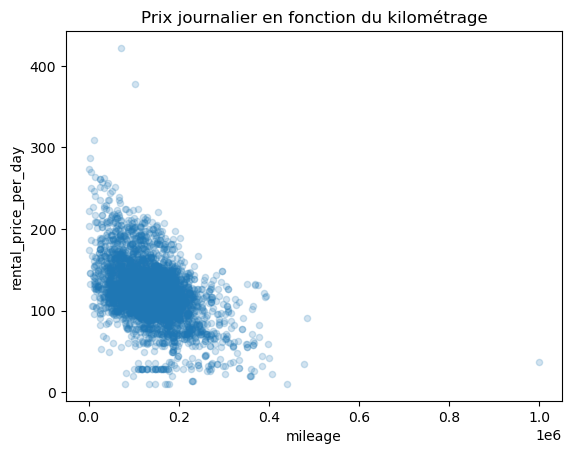

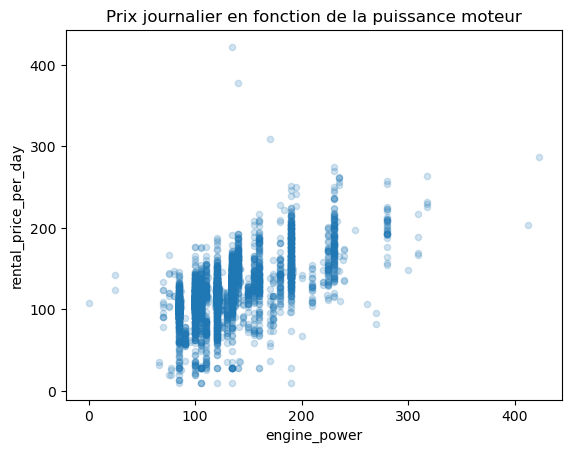

In [23]:
# Relationship between numeric features and rental price
# Mileage vs price (expected negative relationship)
_ = df_pricing.plot.scatter(
    x="mileage",
    y="rental_price_per_day",
    alpha=0.2,
    title="Prix journalier en fonction du kilométrage",
)

# Engine power vs price (expected positive relationship)
_ = df_pricing.plot.scatter(
    x="engine_power",
    y="rental_price_per_day",
    alpha=0.2,
    title="Prix journalier en fonction de la puissance moteur",
)

# Pearson correlations (numeric variables only)
num_cols = ["mileage", "engine_power", "rental_price_per_day"]
df_pricing[num_cols].corr()

<div style="font-size:0.85rem">
Lecture des résultats (corrélations + nuages de points)

- Corrélations numériques
    - rental_price_per_day est négativement corrélé au kilométrage (mileage) : -0,45 → plus une voiture a roulé, plus le prix journalier tend à baisser.
    - rental_price_per_day est positivement corrélé à la puissance moteur (engine_power) : +0,63 → les véhicules plus puissants sont loués plus cher.
    - La corrélation entre mileage et engine_power est proche de 0 (≈ -0,05) → ces deux variables sont quasiment indépendantes dans cet échantillon.

- Nuage de points – Prix vs Kilométrage
    - On observe une tendance décroissante du prix lorsque le kilométrage augmente.
    - La dispersion est forte pour les faibles kilométrages (de nombreux véhicules « quasi neufs » à des prix variés).
    - Quelques valeurs atypiques (prix très bas/élevés ou kilométrages très élevés) existent mais restent peu nombreuses.

- Nuage de points – Prix vs Puissance
    - La relation est croissante : le prix augmente avec la puissance.
    - Les bandes verticales reflètent des paliers de puissance (valeurs discrètes proposées par les constructeurs).
    - L’hétéroscédasticité (dispersion qui grandit avec la puissance) suggère que la variabilité de prix est plus élevée pour les voitures puissantes (effet d’équipements/segments).

Implications rapides pour la tarification / le modèle :
- engine_power et mileage sont deux variables explicatives clés à conserver.
- Penser à gérer les outliers et à tester des transformations (p. ex. log du prix) pour mieux modéliser l’hétéroscédasticité.
- Les paliers visibles peuvent justifier des effets non linéaires (splines, binning, termes quadratiques) sur engine_power.

</div>

In [25]:
# Average daily rental price by brand (model_key),sorted from highest to lowest to assess brand price positioning
top_models = (
    df_pricing.groupby("model_key")["rental_price_per_day"]
    .mean()
    .sort_values(ascending=False)
)
top_models.head(10), top_models.tail(10)

(model_key
 Suzuki         223.875000
 Mini           204.000000
 Lexus          193.000000
 Maserati       188.666667
 Subaru         182.340909
 SEAT           181.239130
 Mitsubishi     170.675325
 KIA Motors     159.000000
 Alfa Romeo     157.666667
 Lamborghini    157.500000
 Name: rental_price_per_day, dtype: float64,
 model_key
 PGO         126.090909
 Mercedes    121.360825
 Renault     120.609170
 BMW         117.432890
 Nissan      111.130909
 Ford        111.000000
 Citroën     108.764706
 Peugeot     104.917445
 Fiat         93.000000
 Mazda        67.000000
 Name: rental_price_per_day, dtype: float64)

<div style="font-size:0.85rem">
Lecture rapide – Prix moyen par marque (model_key)

- Le tableau affiche la moyenne du prix/jour par marque puis triée du plus cher au moins cher.
- En haut du classement, on trouve des marques avec des prix moyens élevés (p. ex. Suzuki, Mini, Lexus, Maserati, Subaru, SEAT, Mitsubishi, KIA Motors, Alfa Romeo, Lamborghini).

Cela reflète à la fois le positionnement de gamme et la composition du parc (SUV/versions sportives, équipements, puissance).

- En bas, des marques plus grand public (Mazda, Fiat, Peugeot, Citroën, Ford, Nissan, BMW, Renault, Mercedes, PGO ici) présentent des prix moyens plus bas sur cet échantillon.

Points d’attention :
- Ces moyennes ne tiennent pas compte des différences internes aux marques (type de carrosserie, puissance, âge/kilométrage, options…).
- Le nombre d’annonces par marque peut varier fortement : une moyenne sur peu d’observations peut être instable.
- Il est utile d'examiner aussi la médiane et l’écart-type, voire de filtrer par segment (ex. SUV vs citadine) pour des comparaisons plus justes.

Prochaines étapes suggérées :
- Ajouter un compte d’annonces par marque et masquer celles avec effectif trop faible.
- Comparer les prix à caractéristiques égales (puissance, kilométrage, type de véhicule) pour isoler l’effet “marque”.
- Visualiser par marque des intervalles de confiance ou barres d’erreur (σ) pour voir l’incertitude.

</div>

In [26]:
# Build a mapping between each model_key and its associated car types

pd.set_option("display.max_colwidth", None)

if {"model_key", "car_type"}.issubset(df.columns):

    # Keep relevant columns and clean string formatting
    df_map = df[["model_key", "car_type"]].dropna().copy()
    df_map["model_key"] = df_map["model_key"].str.lower().str.strip()
    df_map["car_type"] = df_map["car_type"].str.lower().str.strip()

    # List unique car types per model
    model_car_types = (
        df_map.groupby("model_key")["car_type"]
        .unique()
        .reset_index()
        .sort_values("model_key")
    )

    display(model_car_types)

else:
    print("Required columns ('model_key', 'car_type') are missing from the dataset.")

,model_key,car_type
0,alfa romeo,[hatchback]
1,audi,"[estate, hatchback, sedan, van]"
2,bmw,"[estate, hatchback, sedan, subcompact, suv, van]"
3,citroën,"[convertible, coupe, estate, hatchback, sedan, subcompact]"
4,ferrari,"[hatchback, sedan]"
5,fiat,"[hatchback, subcompact]"
6,ford,[hatchback]
7,honda,[sedan]
8,kia motors,[hatchback]
9,lamborghini,"[hatchback, sedan]"


In [27]:
# Map each model to the set of available paint colors

pd.set_option("display.max_colwidth", None)

# Keep relevant columns and standardize text formatting
df_map = df[["model_key", "paint_color"]].copy()
df_map["model_key"] = df_map["model_key"].astype(str).str.lower().str.strip()
df_map["paint_color"] = df_map["paint_color"].astype(str).str.lower().str.strip()

# Aggregate unique paint colors per model
model_paint_color = (
    df_map.groupby("model_key")["paint_color"]
    .unique()
    .reset_index()
    .sort_values("model_key")
)

display(model_paint_color)

,model_key,paint_color
0,alfa romeo,[grey]
1,audi,"[blue, white, black, grey, brown, silver, green, red, beige]"
2,bmw,"[red, grey, white, silver, blue, black, green, brown, orange, beige]"
3,citroën,"[black, grey, white, red, silver, blue, beige, brown, green]"
4,ferrari,"[black, silver, grey, white, blue, brown]"
5,fiat,"[black, white]"
6,ford,"[red, white, grey, black, silver]"
7,honda,[brown]
8,kia motors,"[silver, black, beige]"
9,lamborghini,"[grey, white]"


In [28]:
# Check how many times each (model_key, car_type) combination appears in the data
df_check = df.copy()
df_check["model_key"] = df_check["model_key"].str.lower().str.strip()
df_check["car_type"] = df_check["car_type"].str.lower().str.strip()

pair_counts = (
    df_check.groupby(["model_key", "car_type"])
    .size()
    .reset_index(name="count")
    .sort_values("count")
)

pair_counts.head(20)

,model_key,car_type,count
31,mini,sedan,1
54,renault,suv,1
49,porsche,subcompact,1
44,pgo,convertible,1
34,nissan,van,1
28,mazda,sedan,1
25,lamborghini,sedan,1
24,lamborghini,hatchback,1
22,honda,sedan,1
20,fiat,subcompact,1


In [29]:
# Identify rare (model_key, car_type) combinations with very low support
low_freq = pair_counts[pair_counts["count"] < 5]
low_freq

,model_key,car_type,count
31,mini,sedan,1
54,renault,suv,1
49,porsche,subcompact,1
44,pgo,convertible,1
34,nissan,van,1
28,mazda,sedan,1
25,lamborghini,sedan,1
24,lamborghini,hatchback,1
22,honda,sedan,1
20,fiat,subcompact,1


In [30]:
# Quantify the overall impact of rare (model_key, car_type) combinations
n_impacted = low_freq["count"].sum()
n_total = len(df_check)

print(f"Voitures potentiellement incorrectes : {n_impacted:,}")
print(f"Impact : {n_impacted / n_total * 100:.2f} % du dataset")

Voitures potentiellement incorrectes : 36
Impact : 0.74 % du dataset


In [31]:
# List suspicious car_type values per model for manual inspection
anomalies = (
    low_freq.groupby("model_key")["car_type"]
    .apply(list)
    .reset_index(name="car_types_suspectes")
)

anomalies

,model_key,car_types_suspectes
0,alfa romeo,[hatchback]
1,audi,[van]
2,bmw,[van]
3,ferrari,[hatchback]
4,fiat,"[subcompact, hatchback]"
5,honda,[sedan]
6,kia motors,[hatchback]
7,lamborghini,"[sedan, hatchback]"
8,lexus,[sedan]
9,mazda,[sedan]
